In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.features import preprocessing

In [2]:
%run utils/base.py
%run utils/loading.py
%run utils/attention_graph.py
%run utils/mlflow_query.py

In [29]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"))
mlflow_helper.query_runs(pkl_file=Path("mlflow_run_df.pkl"))

Initialized with 56 MLFlow runs from pkl


Querying data per run...:   0%|          | 0/65 [00:00<?, ?it/s]/home/vincenzo/code/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.run_df = self.run_df.append(
/home/vincenzo/code/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.run_df = self.run_df.append(
/home/vincenzo/code/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.run_df = self.run_df.append(
/home/vincenzo/code/Domain-Guided-Monitoring/notebooks/utils/mlflow_query.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future vers

In [30]:
huawei_df = mlflow_helper.huawei_run_df(
    valid_x_columns=["log_cluster_template", "fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template_90"],
    valid_y_columns=["attributes", "coarse_log_cluster_template"],
    include_drain_hierarchy=True,
)
huawei_df = huawei_df[
    huawei_df["data_params_ModelConfigbase_feature_embeddings_trainable"].astype(str) == "False"
]

huawei_df.groupby(by=[
    "data_params_SequenceConfigx_sequence_column_name",
    "data_params_SequenceConfigy_sequence_column_name",
    "data_tags_model_type",
]).agg({
    "info_run_id": len
})

info_run_id
data_params_SequenceConfigx_sequence_column_name data_params_SequenceConfigy_sequence_column_name data_tags_model_type             
coarse_log_cluster_template                      attributes                                       causal                          3
                                                                                                  gram                            3
                                                                                                  simple                          3
                                                                                                  text                            3
fine_log_cluster_template                        attributes                                       causal                          4
                                                                                                  gram                            4
                                                                                                  simple                          4
                                                                                                  text                            3

# Drain Hierarchy - Suggested Templates

In [5]:
run_id = huawei_df[
    (huawei_df["data_params_SequenceConfigx_sequence_column_name"] == "fine_log_cluster_template")
    & (huawei_df["data_params_SequenceConfigy_sequence_column_name"] == "attributes")
    & (huawei_df["data_tags_model_type"] == "gram")
]["info_run_id"].iloc[0]
run_id

'f54a95d96d944a16aca39903a5e0355d'

In [6]:
feature_node_mapping = create_graph_visualization(
    run_id=run_id, 
    local_mlflow_dir=mlflow_helper.local_mlflow_dir,
    threshold=0.2, 
    run_name='drain_hierarchy', 
    use_node_mapping=False)

In [28]:
original_logs = df = pd.DataFrame(
    pd.read_csv('../data/logs_aggregated_concurrent.csv')["Payload"].fillna("").astype(str).replace(np.nan, "", regex=True).dropna().drop_duplicates().reset_index(drop=True)
)
drain = preprocessing.Drain(
    preprocessing.DrainParameters(
        depth=huawei_df[
            huawei_df["info_run_id"] == run_id
        ]["data_params_HuaweiPreprocessorConfigfine_drain_log_depth"].astype(int).iloc[0],
        st=huawei_df[
            huawei_df["info_run_id"] == run_id
        ]["data_params_HuaweiPreprocessorConfigfine_drain_log_st"].astype(float).iloc[0],
        rex=[
            ("(/|)([0-9]+\.){3}[0-9]+(:[0-9]+|)(:|)", ""),
            ("[^a-zA-Z0-9\-\.]", " "),
            ("[^a-zA-Z\d\s:]", ""),
        ],
    ),
    data_df=original_logs,
    data_df_column_name="Payload",
)
drain_result = drain.load_data().drop_duplicates().set_index("log_idx")
log_result_df = pd.merge(
    original_logs, 
    drain_result, 
    left_index=True, 
    right_index=True, 
    how="left"
).rename(columns={
    "cluster_template": "fine_log_cluster_template"
})[["Payload", "fine_log_cluster_template"]]

log_result_df

Generating DRAIN clusters from log_df: 100%|██████████| 163/163 [00:00<00:00, 12996.08it/s]


,Payload,fine_log_cluster_template
0,Security group rule updated ['78c81907-a991-41...,security group rule updated *
1,Could not find domain: Default.: DomainNotFoun...,could not find domain default domainnotfound c...
2,"172.17.0.2 - - [25/Nov/2019 15:01:48] ""GET /v2...",25 nov 2019 15 01 * get v2 schemas image http ...
3,http://130.149.249.123:8774/v2.1/dbf4ab7d6e844...,http v21 dbf4ab7d6e84449e93e02f305534200b serv...
4,Unexpected exception in API method: HTTPIntern...,unexpected exception in api method httpinterna...
...,...,...
158,"- - - [25/Nov/2019:15:03:46 +0100] ""POST /v3/a...",25 nov 2019 15 * * 0100 post v3 auth tokens ht...
159,"- - - [25/Nov/2019:15:03:46 +0100] ""POST /v3/a...",25 nov 2019 15 * * 0100 post v3 auth tokens ht...
160,"- - - [25/Nov/2019:15:03:46 +0100] ""GET / HTTP...",25 nov 2019 15 * * 0100 get http 11 300 270 * ...
161,"- - - [25/Nov/2019:15:03:46 +0100] ""DELETE /v3...",25 nov 2019 15 03 * 0100 delete v3 projects * ...


In [8]:
attention_weights = load_attention_weights(run_id=run_id, local_mlflow_dir=mlflow_helper.local_mlflow_dir)
attention_representations = []

for fine_template in attention_weights:
    best_representation = sorted([(k,float(v)) for k,v in attention_weights[fine_template].items()], key=lambda x: x[1], reverse=True)[0]
    attention_representation = {
        "attention_representation_" + str(x): (best_representation[0] if float(best_representation[1]) > x else fine_template)
        for x in [0.5, 0.9]
    }
    attention_representation["fine_log_cluster_template"] = fine_template[len("fine_log_cluster_template#"):]
    attention_representation["attention_representation"] = best_representation[0]
    attention_representations.append(attention_representation)

pd.DataFrame.from_records(attention_representations)

,attention_representation_0.5,attention_representation_0.9,fine_log_cluster_template,attention_representation
0,python_module->nova->virt,fine_log_cluster_template#image 5ddb8ba7760944...,image 5ddb8ba77609443eab6002b3656b334b at var ...,python_module->nova->virt
1,http_status->200,fine_log_cluster_template#25 nov 2019 * * * 01...,25 nov 2019 * * * 0100 put allocations * http ...,http_status->200
2,python_module->neutron->db->agents,fine_log_cluster_template#agent healthcheck fo...,agent healthcheck found 3 dead agents out of 8...,python_module->neutron->db->agents
3,programname#glance-api,fine_log_cluster_template#25 nov 2019 17 49 * ...,25 nov 2019 17 49 * get v2 images * http 11 20...,programname#glance-api
4,programname#glance-api,fine_log_cluster_template#25 nov 2019 16 21 * ...,25 nov 2019 16 21 * get v2 images * http 11 20...,programname#glance-api
...,...,...,...,...
1441,python_module->heat->engine,python_module->heat->engine,loading etc heat environmentd defaultyaml,python_module->heat->engine
1442,python_module->heat->engine,python_module->heat->engine,registered plugin user false aws s3 bucket cla...,python_module->heat->engine
1443,python_module->neutron->plugins->ml2,fine_log_cluster_template#open vswitch agent s...,open vswitch agent s supported vnic types norm...,python_module->neutron->plugins->ml2
1444,http_status->200,fine_log_cluster_template#25 nov 2019 * * * 01...,25 nov 2019 * * * 0100 put resource providers ...,http_status->200


In [9]:
def extract_type_template(attention_representation: str):
    if "_log_cluster_template#" in attention_representation:
        splitted = attention_representation.split("#")
        return (splitted[0], " ".join(splitted[1:]))
    elif attention_representation.startswith("coarse_log_cluster_path#"):
        splitted = attention_representation.split("#")
        return (splitted[0], " ".join(splitted[1:]) + " ***")
    elif attention_representation.startswith("coarse_log_cluster_path->"):
        splitted = attention_representation.split("->")
        return (splitted[0] + "_" + str(len(splitted)-2), " ".join(splitted[2:]) + " ***")
    else:
        return ("???", attention_representation)

In [10]:
drain_df = pd.merge(
    log_result_df, 
    pd.DataFrame.from_records(attention_representations),
    how="left",
    on="fine_log_cluster_template").fillna("")
for column in [x for x in drain_df.columns if x.startswith("attention_representation")]:
    drain_df[column + "_type"] = drain_df[column].apply(lambda x: extract_type_template(str(x))[0])
    drain_df[column + "_template"] = drain_df[column].apply(lambda x: extract_type_template(str(x))[1])

drain_df[["attention_representation", "attention_representation_type", "attention_representation_template"]].describe()

,attention_representation,attention_representation_type,attention_representation_template
count,163,163,163
unique,11,1,11
top,,???,
freq,121,163,121


In [11]:
drain_grouped = drain_df.groupby(by=["attention_representation_type"]).agg({
    "Payload": lambda x: len(set(x)),
    "fine_log_cluster_template": lambda x: len(set(x)), 
    "attention_representation_template": lambda x: len(set(x)),
})
drain_grouped

,Payload,fine_log_cluster_template,attention_representation_template
attention_representation_type,,,
???,163,37,11


In [18]:
melt_df = drain_grouped.reset_index(drop=False).melt(
    id_vars=["attention_representation_type"],
    value_vars=["Payload", "fine_log_cluster_template", "attention_representation_template"],
    value_name="num_examples",
    var_name="type")
melt_df

,attention_representation_type,type,num_examples
0,???,Payload,163
1,???,fine_log_cluster_template,37
2,???,attention_representation_template,11


In [19]:

g = sns.catplot(data=melt_df,
    x="attention_representation_type", 
    y="num_examples",
    hue="type",
    order=[
        "fine_log_cluster_template", "0_log_cluster_template", "1_log_cluster_template", "2_log_cluster_template", 
        "coarse_log_cluster_template", "coarse_log_cluster_path"
    ] + ["coarse_log_cluster_path_" + str(x) for x in reversed(range(
        max([int(x.split("_")[-1]) for x in drain_grouped.index if x.startswith("coarse_log_cluster_path_")]) + 1
    ))],
    #col="type",
    kind="bar",
    sharey=False,
    palette="Set2",
    legend=False,
).set_xticklabels(rotation=90).set_axis_labels("", "number of log lines")
plt.tight_layout()
plt.savefig("drain_distribution.png", dpi=100)

ValueError: max() arg is an empty sequence

In [26]:
drain_df[
    drain_df["attention_representation_type"] == "coarse_log_cluster_path_0"
][["Payload", "attention_representation"]]

,Payload,attention_representation


In [27]:
drain_df["attention_log_cluster_template_50"] = drain_df["attention_representation_0.5"]
drain_df["attention_log_cluster_template_90"] = drain_df["attention_representation_0.9"]
drain_df[
    ["Payload", "attention_log_cluster_template_50", "attention_log_cluster_template_90"]
].to_csv("drain_attention_clusters.csv", index=False)

In [28]:
pd.read_csv("drain_attention_clusters.csv").describe()

,Payload,attention_log_cluster_template_50,attention_log_cluster_template_90
count,163,42,42
unique,163,14,14
top,Security group rule updated ['78c81907-a991-41...,fine_log_cluster_template#25 nov 2019 15 * * 0...,fine_log_cluster_template#25 nov 2019 15 * * 0...
freq,1,12,12


In [61]:
attention_importances = calculate_attention_importances(attention_weights)
examples_extensions = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->9->extension"] if x[1] > 0.9]
examples_instance = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->7->instance"] if x[1] > 0.9]
examples_instance2 = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->9->instance->*"] if x[1] > 0.9]
examples_automatically = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->10->automatically"] if x[1] > 0.9]
examples_cleaning= [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->4->cleaning->stale"] if x[1] > 0.9]
examples_date = [x[0].split("#")[1] for x in attention_importances["coarse_log_cluster_path->17"] if x[1] > 0.9]

examples_date

KeyError: 'coarse_log_cluster_path->9->extension'

In [30]:
attention_weights["fine_log_cluster_template#25 nov 2019 19 * * 0100 get v3 auth tokens http 11 200 * * pythonkeystoneclient"]

{'fine_log_cluster_template#25 nov 2019 19 * * 0100 get v3 auth tokens http 11 200 * * pythonkeystoneclient': '0.0051629776',
 'root': '0.005941136',
 'Hostname->wally': '0.0064578936',
 'Hostname': '0.0065857354',
 'programname': '0.005623054',
 'Hostname#wally113': '0.007452865',
 'http_status->200': '0.0029807352',
 'http_status': '0.0022917187',
 'programname->keystone->apache': '0.0029810918',
 'programname->keystone': '0.0023812656',
 'url_cluster_template->v3': '0.0061864443',
 'url_cluster_template': '0.009546073',
 'http_method': '0.002368272',
 'http_method#get': '0.0025811682',
 'http_status#200.0': '0.062440813',
 'url_cluster_template#v3 auth tokens': '0.12454709',
 'url_cluster_template->v3->auth->tokens': '0.004407823',
 'url_cluster_template->v3->auth': '0.0055570668',
 'programname#keystone-apache-admin-access': '0.00912741',
 'programname->keystone->apache->admin->access': '0.71425986',
 'programname->keystone->apache->admin': '0.011119469'}

In [57]:
attention_weights[[x for x in attention_importances["coarse_log_cluster_path->9->extension"] if x[1] < 0.9][0][0]]

KeyError: 'coarse_log_cluster_path->9->extension'

In [32]:
[
    (x, ys) for x,ys in attention_importances.items() if 
    "either ensure your deployment is ready" in x 
    and x.startswith("coarse_log_cluster_template") 
    and "* * * * * * * * * * * *" in x
    and len([y for y in ys if y[1] > 0.2]) == 3
]

[]

# Experiment Results

In [20]:
huawei_metrics_df = mlflow_helper.load_best_metrics_for_ids(set(huawei_df["info_run_id"]))
huawei_metrics_df

Querying metrics for runs: 100%|██████████| 19/19 [00:01<00:00, 14.95it/s]


,val_top_10_categorical_accuracy_cp4_history_best,val_top_10_categorical_accuracy_cp4_times_best,val_top_20_categorical_accuracy_p3_history_best,val_top_20_categorical_accuracy_p3_times_best,val_top_10_categorical_accuracy_p2_history_best,val_top_10_categorical_accuracy_p2_times_best,top_20_categorical_accuracy_p2_history_best,top_20_categorical_accuracy_p2_times_best,val_top_10_categorical_accuracy_p0_history_best,val_top_10_categorical_accuracy_p0_times_best,...,data_tags_sequence_type,data_tags_task_type,info_artifact_uri,info_end_time,info_experiment_id,info_lifecycle_stage,info_run_uuid,info_start_time,info_status,info_user_id
0,1.0,1670772821139,0.717087,1670772821144,0.068493,1670772821140,0.517241,1670772821131,0.0,1670772821139,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670773e+12,719923802334351993,active,4c040a114fc44dc6aa6af5786a1b7688,1.670771e+12,FINISHED,pacev
1,1.0,1670792874768,0.800560,1670792874774,0.068493,1670792874770,0.584225,1670792874760,0.0,1670792874769,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670793e+12,719923802334351993,active,efecce66a1484c9dbc514deb95458b67,1.670792e+12,FINISHED,pacev
2,1.0,1670870489110,0.723810,1670870489119,0.068493,1670870489112,0.638922,1670870489096,0.0,1670870489111,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670871e+12,719923802334351993,active,4ac6c90ba3e04d5bb2cc8eaffb6823d3,1.670870e+12,FINISHED,pacev
3,1.0,1670794151167,0.802241,1670794151172,0.095890,1670794151168,0.508522,1670794151159,0.0,1670794151167,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670794e+12,719923802334351993,active,b6f603c41e8c448b83d96474968b1d8e,1.670793e+12,FINISHED,pacev
4,1.0,1670872854519,0.810084,1670872854525,0.068493,1670872854520,0.505747,1670872854511,0.0,1670872854520,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670873e+12,719923802334351993,active,a8ae6990c12345cda801407c9da4f486,1.670872e+12,FINISHED,pacev
5,1.0,1670703309171,0.656022,1670703309176,0.013699,1670703309172,0.489893,1670703309162,0.0,1670703309171,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670703e+12,719923802334351993,active,12b8d4e680d14496bd6e8107cd9b8e3c,1.670702e+12,FINISHED,pacev
6,1.0,1670769912368,0.764146,1670769912373,0.136986,1670769912369,0.583829,1670769912359,0.0,1670769912368,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670770e+12,719923802334351993,active,4a8a584e07ee40b4b1b43aded49854c3,1.670769e+12,FINISHED,pacev
7,1.0,1670871664276,0.787675,1670871664281,0.000000,1670871664277,0.608006,1670871664268,0.0,1670871664276,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670872e+12,719923802334351993,active,f54a95d96d944a16aca39903a5e0355d,1.670871e+12,FINISHED,pacev
8,1.0,1670874386091,0.686275,1670874386096,0.027397,1670874386092,0.498613,1670874386083,0.0,1670874386091,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.670874e+12,719923802334351993,active,fbaf21dfbcfc45e486af92f6d4713b56,1.670873e+12,FINISHED,pacev
9,1.0,1671060352343,0.814006,1671060352348,0.082192,1671060352344,0.673801,1671060352334,0.0,1671060352343,...,huawei_logs,sequence_prediction,file:///home/i40/pacev/Domain-Guided-Monitorin...,1.671060e+12,719923802334351993,active,5835a7e78f1c4230860f4a607652cdd7,1.671059e+12,FINISHED,pacev


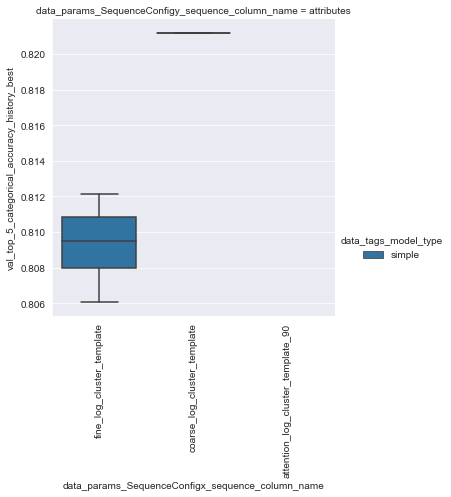

In [21]:
sns.catplot(
    data=huawei_metrics_df[
        (huawei_metrics_df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: x != "log_cluster_template"))
        & (huawei_metrics_df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes"))
        & (huawei_metrics_df["data_tags_model_type"].apply(lambda x: x == "simple"))
    ],
    hue="data_tags_model_type", 
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template_90"],
    kind="box",
    sharey="row",
).set_xticklabels(rotation=90)

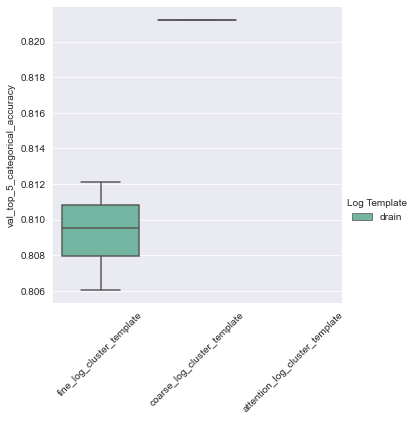

In [22]:
df = huawei_metrics_df.copy()
df["data_tags_model_type"] = df["data_tags_model_type"].apply(lambda x: {
    "gram": "hierarchy",
}.get(x, x))
df["data_params_SequenceConfigx_sequence_column_name"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: {
    "log_cluster_template": "fine_log_cluster_template",
    "attention_log_cluster_template_90": "attention_log_cluster_template",
}.get(x, x))
df["Log Template"] = df["data_params_SequenceConfigx_sequence_column_name"].apply(lambda x: "attention" if "attention" in x else "drain")
g = sns.catplot(
    data=df[
        df["data_params_SequenceConfigy_sequence_column_name"].apply(lambda x: x == "attributes")
        & df["data_tags_model_type"].apply(lambda x: x == "simple")
        &  df["data_params_ModelConfigbase_hidden_embeddings_trainable"].apply(lambda x: x == "False")
    ],
    hue="Log Template",
    x="data_params_SequenceConfigx_sequence_column_name",
    y="val_top_5_categorical_accuracy_history_best",
    row="data_params_SequenceConfigy_sequence_column_name",
    order=["fine_log_cluster_template", "coarse_log_cluster_template", "attention_log_cluster_template"],
    kind="box",
    palette="Set2",
    dodge=False,
).set_xticklabels(rotation=45).set_titles("").set_axis_labels('', "val_top_5_categorical_accuracy")
plt.savefig("drain_results.png", dpi=100, bbox_inches="tight")
plt.show()